In [18]:
import numpy as np
import matplotlib.pyplot as plt
import gauss_quad_lib 
import element_lib
from mpl_toolkits.mplot3d import Axes3D
plt.rcdefaults()
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
from numpy.linalg import solve, norm
from numpy.random import rand

# set the axes color glbally for all plots

plt.rcParams.update({'axes.facecolor':'white'})

In [19]:
N= 20
[a,b,c,d] = [0,1,0,1]
di = (b-a)/N
dj = (d-c)/N
root = [0,0]

In [20]:
nut = np.zeros( ((N+1)*(N+1), 2))
for i in range(0,N+1):
    for j in range(0,N+1):
        id = int( (N+1)*j+i)
        nut[id] = [di*i + root[0], dj*j + root[1]] 

In [21]:
so_tam_giac = N*N*4
triangle = np.zeros((so_tam_giac,3))
for i in range(0,N):
    for j in range(0,N):
        id1 = int(i*(N+1) + j)
        id2 = int(i*(N+1) + j+1)
        id3 = int((i+1)*(N+1) + j)
        id4 = int((i+1)*(N+1) + j+1)
        triangle[2*(N*i + j)] = [id1,id3,id4]
        triangle[2*(N*i+j)+1] = [id1,id2,id4]

In [22]:
#set Dirichlet nut
so_nut = (N+1)**2
Dirichlet = np.zeros(so_nut)  #dang boolean
val_Dirichlet = np.zeros(so_nut) #gia tri khoi tao

independ_re_index = np.zeros(so_nut)     # danh so lai cho nut doc lap
run = 0
for i in range(0, so_nut):
    if(i%(N+1)==0 or i%(N+1)==N or i<=N or i>=N*(N+1)):
        Dirichlet[i] = 1
        val_Dirichlet[i] = 0
    else: 
        independ_re_index[i] = int(run)
        run +=1
Global_matrix_vt = lil_matrix((run,run))


In [23]:

for i in range(0, so_tam_giac):
    for j in range(0, 3):
        p1 = int(triangle[i][j])
        for k in range(j+1,3):
            p2 = int(triangle[i][k])
            p3 = 100
            if(j==0 and k== 1):
                p3 = int(triangle[i][2])
            if(j==0 and k== 2):
                p3 = int(triangle[i][1])
            if(j==1 and k== 2):
                p3 = int(triangle[i][0])    
            if(Dirichlet[p1]==0 and Dirichlet[p2]==0):
                q1 = int(independ_re_index[p1])
                q2 = int(independ_re_index[p2])                
                val= element_lib.Element_Stiff(nut[p1][0],nut[p1][1],
                                                                       nut[p2][0],nut[p2][1],
                                                                     nut[p3][0],nut[p3][1])
                Global_matrix_vt[q1,q2] +=val
                Global_matrix_vt[q2,q1] +=val
            

In [24]:
for i in range(0, so_tam_giac):
    for j in range(0, 3):
        p1 = int(triangle[i][j])
        if(Dirichlet[p1]==0):
            p2=0
            p3=0
            if(j==0):
                p2 = int(triangle[i][1])  
                p3 = int(triangle[i][2])  
            if(j==1):
                p2 = int(triangle[i][0])  
                p3 = int(triangle[i][2]) 
            if(j==2):
                p2 = int(triangle[i][1])  
                p3 = int(triangle[i][0])     
            val= element_lib.Element_Stiff_self(nut[p1][0],nut[p1][1],
                                                                       nut[p2][0],nut[p2][1],
                                                                     nut[p3][0],nut[p3][1])
            q1 = int(independ_re_index[p1])
            Global_matrix_vt[q1,q1]+=val    
        

In [25]:
Global_matrix_vt

<361x361 sparse matrix of type '<class 'numpy.float64'>'
	with 2339 stored elements in List of Lists format>

In [26]:
f = lambda x,y: -2*x*(x-1) -2*y*(y-1)

In [27]:
ve_phai = np.zeros(run)
for i in range(0, so_tam_giac):
    for j in range(0, 3):
        p1 = int(triangle[i][j])
        if(Dirichlet[p1]==0):
            p2=0
            p3=0
            if(j==0):
                p2 = int(triangle[i][1])  
                p3 = int(triangle[i][2])  
            if(j==1):
                p2 = int(triangle[i][0])  
                p3 = int(triangle[i][2]) 
            if(j==2):
                p2 = int(triangle[i][1])  
                p3 = int(triangle[i][0])     
            phi= element_lib.Element_Linear_Polynomial(nut[p1][0],nut[p1][1],
                                                                       nut[p2][0],nut[p2][1],
                                                                     nut[p3][0],nut[p3][1])
            q1 = int(independ_re_index[p1])
            ham= lambda x,y: phi(x,y)*f(x,y)
            ve_phai[q1]+=gauss_quad_lib.integrate_gauss_quad_triangle(ham,nut[p1][0],nut[p1][1],
                                                                       nut[p2][0],nut[p2][1],
                                                                     nut[p3][0],nut[p3][1])  
        

In [28]:
Global_matrix_vt = Global_matrix_vt.tocsr()
u_cord = spsolve(Global_matrix_vt, ve_phai)

In [29]:
poly3d = np.zeros((so_tam_giac, 3, 3))
fc = np.zeros(so_tam_giac)
val_max = 0
val_min = 0
for i in range(0, so_tam_giac):
    ave_col = 0
    for j in range(0, 3):
        p = int(triangle[i,j])
        poly3d[i,j,0] = nut[p][0]
        poly3d[i,j,1] = nut[p][1]
        if(Dirichlet[p] == 0):
            poly3d[i,j,2] = u_cord[int(independ_re_index[p])]
        ave_col += poly3d[i,j,2]/3
    fc[i] = ave_col
    if(i==0):
        val_min = ave_col
        val_max = ave_col
    if (ave_col<val_min):
        val_min = ave_col
    if(ave_col>val_max):
        val_max = ave_col


In [30]:
fc = (fc - val_min)/(val_max-val_min)
col = []
for i in range(0,so_tam_giac):
    red = (0.9,0.2,0)
    blue = (0,0.55,1)
    gl = (0,1/2,1/2)
    r = red[0] *fc[i] + blue[0]*(1-fc[i]) #+ gl[0]*(fc[i]/2)
    g = red[1] *fc[i] + blue[1]*(1-fc[i]) #+ gl[1]*(fc[i]/2)
    b = red[2] *fc[i] + blue[2]*(1-fc[i]) #+ gl[2]*(fc[i]/2)
    col.append((r,g,b))

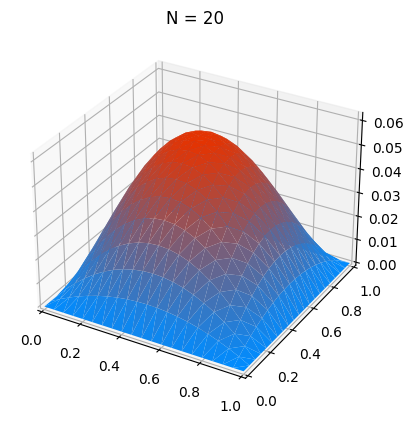

In [35]:

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.add_collection3d(Poly3DCollection(poly3d,facecolors = col, linewidths=1))
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_zlim(val_min,val_max)
plt.title("N = "+ str(N))
plt.show()